In [4]:
import datetime
import sys
from datetime import datetime
from typing import List
from sklearn import preprocessing

from tqdm import tqdm
from utils.forecast import get_dwd_forecast

sys.path.append("/".join(sys.path[0].split("/")[:-1]))

import logging
import time
from enum import Enum
from typing import Callable, Dict, Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec

from studies.utils.forecast import get_dwd_forecast, set_errors_to_zeros
from studies.utils.recent import get_recent

df = get_dwd_forecast(feature="precipitationTotal")
df.head()

,Unnamed: 0,call_time,station_id,provider,time,precipitationTotal
0,0,2024-01-07 00:10:00,Q811,DWD_1,2024-01-06 23:00:00,1
1,1,2024-01-07 00:10:00,Q811,DWD_1,2024-01-07 00:00:00,3
2,2,2024-01-07 00:10:00,Q811,DWD_1,2024-01-07 01:00:00,3
3,3,2024-01-07 00:10:00,Q811,DWD_1,2024-01-07 02:00:00,4
4,4,2024-01-07 00:10:00,Q811,DWD_1,2024-01-07 03:00:00,4


In [5]:
class Feature(Enum):
    PRECIPITATION = 1
    TEMPERATURE = 2


FORECAST_FEATURE_TRANSLATOR = {
    Feature.PRECIPITATION: ("precipitationTotal", "precipitation_forecast"),
    Feature.TEMPERATURE: ("temperature", "air_temperature_forecast"),
}
RECENT_FEATURE_TRANSLATOR = {
    Feature.PRECIPITATION: (
        "precipitation",
        "precipitation_real",
        "  R1",
        ["QN_8", "RS_IND", "WRTR", "eor"],
    ),
    Feature.TEMPERATURE: (
        "air_temperature",
        "air_temperature_real",
        "TT_TU",
        ["QN_9", "RF_TU", "eor"],
    ),
}


class DWD_Dataset:
    def __init__(self, source_path: str, feature: Feature = None):
        self._source_path = source_path
        # load station meta information
        self._stations = pd.read_csv(self._source_path + "/stations.tsv", sep="\t")

        if feature is None:
            # load all specified features in Features enum
            precipitation_forecast = self._load_forecast(Feature.PRECIPITATION)
            temperature_forecast = self._load_forecast(Feature.TEMPERATURE)
            # merge all feature; There are more temperature values than forecast values -> left outter join
            self._forecast = pd.merge(
                precipitation_forecast,
                temperature_forecast,
                how="left",
                on=["call_time", "station_id", "provider", "time"],
            )

            # get recent 
            precipitation_real = self._load_recent(Feature.PRECIPITATION)
            temperature_real = self._load_recent(Feature.TEMPERATURE)
            self._real_data = pd.merge(
                precipitation_real,
                temperature_real,
                how="left",
                on=["station_id", "time"],
            )

        elif isinstance(feature, Feature):
            # load a specific feature
            self._forecast = self._load_forecast(feature)
            # get recent
            self._real_data = self._load_recent(feature)

        else:
            logging.error(
                f"the given feature: {feature} is neither is None nor an element of Feature enum."
            )
            return

        # clean data by removing every point which is outside every forecast
        min_time = min(self._forecast["time"])
        self._real_data = self._real_data[self._real_data["time"] >= min_time]
        # ... and also vise versa on forecasts we can't evaluate because we don't have a reference
        max_time = max(self._real_data["time"])
        self._forecast = self._forecast[self._forecast["time"] <= max_time]

        # create a merge dataset where we link forecasts and recent data
        self._merge = pd.merge(
            self._forecast, self._real_data, on=["time", "station_id"], how="left"
        )
       
        # add difference
        if feature is None:
            self._merge.insert(
                len(self._merge.columns),
                "precipitation_error",
                self._merge["precipitation_forecast"] - self._merge["precipitation_real"],
            )
            self._merge.insert(
                len(self._merge.columns),
                "air_temperature_error",
                self._merge["air_temperature_forecast"] - self._merge["air_temperature_real"],
            )   
        elif isinstance(feature, Feature):
            name = RECENT_FEATURE_TRANSLATOR[feature]
            self._merge.insert(
                len(self._merge.columns),
                f"{name}_error",
                self._merge[f"{name}_forecast"] - self._merge[f"{name}_real"],
            )

        # TODO: correct this. ASSIGNING 0 TO MEASUREMENT ERRORS IS PURELY WRONG

    def get_forecast(self, station_id: int = 0, model: int = 0):
        forecast = self._filter_df(self._forecast, station_id, model)
        return forecast

    def get_merge(self, station_id: int = 0, model: int = 0):
        merge = self._filter_df(self._merge, station_id, model)
        return merge

    def get_historical(self, station_id: int = 0, model: int = 0):
        real_data = self._filter_df(self._real_data, station_id, model)
        return real_data

    def get_matrix(self, data_column: str):
        """shape: (num_api_calls, num_stations, num_predictions_into_future)

        Args:
            data_column (str): _description_

        Returns:
            _type_: _description_
        """
        if data_column not in self._merge.columns:
            logging.error(
                f"{data_column} not in {self._merge.columns}. Not possible to create matrix"
            )
            return
        errors = []
        merge = self._merge[self._merge["provider"] == "DWD_1"]
        station_ids = merge["station_id"].unique()
        for call_time in sorted(merge["call_time"].unique()):
            same_call_time = merge[merge["call_time"] == call_time]
            call_time_errors = []
            for station_id in station_ids:
                call_time_error = same_call_time[
                    same_call_time["station_id"] == station_id
                ]["precipitation_error"].values
                # This is a HACK and needs to be resolved
                # THIS ONLY WORKS FOR MODEL 1
                call_time_error = call_time_error[:72]
                if len(call_time_error) < 72:
                    continue
                call_time_errors.append(call_time_error)
            if len(call_time_errors):
                errors.append(np.stack(call_time_errors))

        # shape: (num_api_calls, num_stations, num_predictions_into_future)
        errors = np.stack(errors)
        return errors

    def _load_forecast(self, feature: Feature) -> pd.DataFrame:
        forecast_feature_name, forecast_column_name = FORECAST_FEATURE_TRANSLATOR[
            feature
        ]
        # get forecast
        forecast = get_dwd_forecast(forecast_feature_name, self._source_path)
        # drop unnamed colum
        forecast = forecast.drop(columns="Unnamed: 0")
        # rename forecast_column
        forecast = forecast.rename(
            columns={forecast_feature_name: forecast_column_name}
        )
        # convert kennungen to real ids
        # huge speedup to turn the data-structure in the lightweight dict
        kennung_id_dict = dict(
            zip(self._stations["Stations-kennung"], self._stations["Stations_ID"])
        )
        forecast["station_id"] = forecast["station_id"].apply(
            kennung_id_dict.__getitem__
        )

        # if temperature do rescale
        if feature == Feature.TEMPERATURE or feature is  None:
            forecast[forecast_column_name] = (forecast[forecast_column_name] - 32) * 5 / 9

        return forecast

    def _load_recent(self, feature: Feature) -> pd.DataFrame:
        (
            property,
            recent_column_name,
            data_column_name,
            columns_to_drop,
        ) = RECENT_FEATURE_TRANSLATOR[feature]
        precipitation = get_recent(feature=property)
        # clean columns
        real_data = precipitation.drop(columns=columns_to_drop)
        # rename columns
        real_data = real_data.rename(
            columns={
                "MESS_DATUM": "time",
                data_column_name: recent_column_name,
                "STATIONS_ID": "station_id",
            }
        )
        # TODO: correct this. ASSIGNING 0 TO MEASUREMENT ERRORS IS PURELY WRONG
        real_data[recent_column_name] = real_data[recent_column_name].apply(set_errors_to_zeros)

        return real_data

    def _filter_errors(self, threshold: float = 900):
        """_summary_

        Args:
            threshold (float, optional): disable it with values > 999. Defaults to 900.
        """
        # find mistakes in forecasts
        mask_1 = self._forecast["precipitation_forecast"].abs() > threshold
        mask_2 = self._real_data["precipitation_real"].abs() > threshold
        mask = mask_1 & mask_2

        print(len())
        self._forecast = self._forecast[mask]
        self._real_data = self._real_data[mask]
        self._merge = self._merge[mask]

    @staticmethod
    def _filter_df(df: pd.DataFrame, station_id: int = 0, model: int = 0):
        if station_id > 0:
            df = df[df["station_id"] == station_id]
        
        if "provider" not in df.columns or model == 0:
            pass
        elif model > 2 or model < 0:
            raise ValueError(
                "Choose either model 1 or 2. If you want to obtain both: 0"
            )
        else:
            df = df[df["provider"] == f"DWD_{model}"]
            df = df.drop(columns=["provider"])

        return df


# dataset = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION)
dataset = DWD_Dataset(source_path="../data/dwd")

In [6]:
dataset.get_forecast()

,call_time,station_id,provider,time,precipitation_forecast,air_temperature_forecast
0,2024-01-07 00:10:00,757,DWD_1,2024-01-06 23:00:00,1,-1.111111
1,2024-01-07 00:10:00,757,DWD_1,2024-01-07 00:00:00,3,-4.444444
2,2024-01-07 00:10:00,757,DWD_1,2024-01-07 01:00:00,3,-5.555556
3,2024-01-07 00:10:00,757,DWD_1,2024-01-07 02:00:00,4,-6.111111
4,2024-01-07 00:10:00,757,DWD_1,2024-01-07 03:00:00,4,-6.666667
...,...,...,...,...,...,...
165885,2023-12-20 00:10:00,2575,DWD_2,2023-12-29 08:00:00,0,NaN
165886,2023-12-20 00:10:00,2575,DWD_2,2023-12-29 11:00:00,3,NaN
165887,2023-12-20 00:10:00,2575,DWD_2,2023-12-29 14:00:00,6,NaN
165888,2023-12-20 00:10:00,2575,DWD_2,2023-12-29 17:00:00,16,NaN


First look at one specific station

In [7]:
STATION_ID = 257

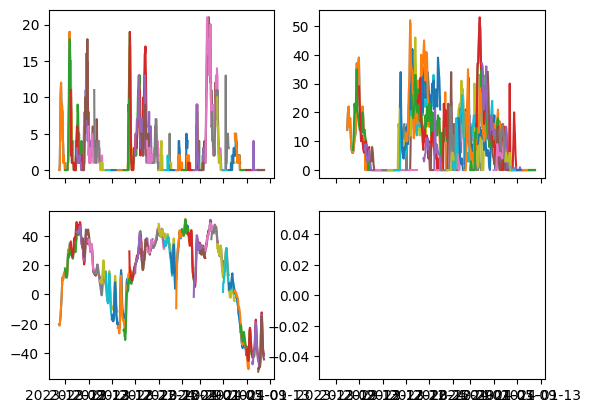

In [8]:
forecast1 = dataset.get_forecast(model=1, station_id=STATION_ID)
forecast2 = dataset.get_forecast(model=2, station_id=STATION_ID)


fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
for call_time in sorted(forecast1["call_time"].unique()):
    sub_df = forecast1[forecast1["call_time"] == call_time]
    t = sub_df["time"]
    values = sub_df["precipitation_forecast"]
    axs[0, 0].plot(t, values)
    values = sub_df["air_temperature_forecast"]
    axs[1, 0].plot(t, values)
    
    sub_df = forecast2[forecast2["call_time"] == call_time]
    t = sub_df["time"]
    values = sub_df["precipitation_forecast"]
    axs[0, 1].plot(t, values)
    values = sub_df["air_temperature_forecast"]
    axs[1, 1].plot(t, values)
    

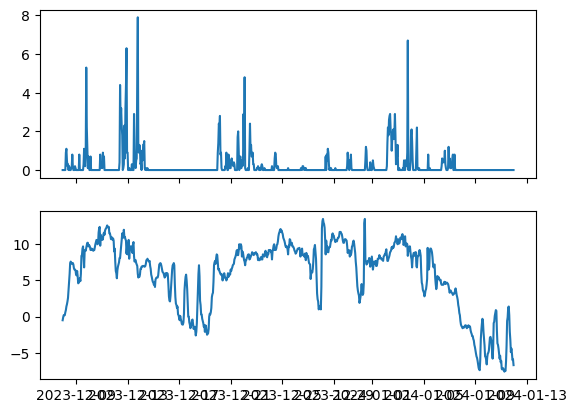

In [9]:
real_data = dataset.get_historical(model=1, station_id=STATION_ID)


fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(real_data["time"], real_data["precipitation_real"])
axs[1].plot(real_data["time"], real_data["air_temperature_real"])

              call_time  station_id                time  \
712 2024-01-07 00:10:00         257 2024-01-06 23:00:00   
713 2024-01-07 00:10:00         257 2024-01-07 00:00:00   
714 2024-01-07 00:10:00         257 2024-01-07 01:00:00   
715 2024-01-07 00:10:00         257 2024-01-07 02:00:00   
716 2024-01-07 00:10:00         257 2024-01-07 03:00:00   

     precipitation_forecast  air_temperature_forecast  precipitation_real  \
712                       5                  2.777778                 0.4   
713                       4                  2.222222                 0.6   
714                       5                  1.666667                 0.1   
715                       5                  1.111111                 0.1   
716                       4                  1.666667                 0.1   

     air_temperature_real  precipitation_error  air_temperature_error  
712                   3.7                  4.6              -0.922222  
713                   3.3             

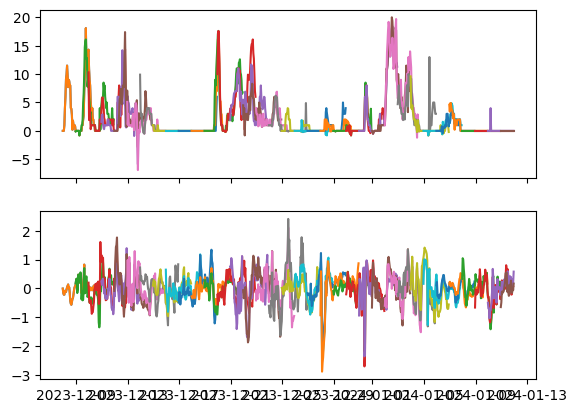

In [10]:
from studies.utils.arithmetric import normalized


merge = dataset.get_merge(model=1, station_id=STATION_ID)

print(merge.head())
fig, axs = plt.subplots(nrows=2, sharex=True)
for call_time in sorted(merge["call_time"].unique()):
    sub_df = merge[merge["call_time"] == call_time]
    t = sub_df["time"]
    error = sub_df["precipitation_error"]
    axs[0].plot(t, error)
    error = sub_df["air_temperature_forecast"] - sub_df["air_temperature_real"]
    # normalize
    norm_forecast = normalized(sub_df["air_temperature_forecast"].values)
    norm_real = normalized(sub_df["air_temperature_real"].values)
    axs[1].plot(t, norm_forecast - norm_real)
    # axs[1].plot(t, norm_forecast)
    # axs[1].plot(t, norm_real)
    

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

In [11]:
from random import shuffle


merge = dataset.get_merge(model=1)

mean_error = merge["precipitation_error"].mean()
# concatenate real values as forecasts
concat = np.concatenate([merge["precipitation_forecast"], merge["precipitation_real"]])
shuffle(concat)
shuffle_error = concat[:len(merge)] - concat[len(merge):]

mean error of shuffled data:  -0.0042877282639822
Significance level of mean error= 1.3560334383329296 = 0.0532744454479368


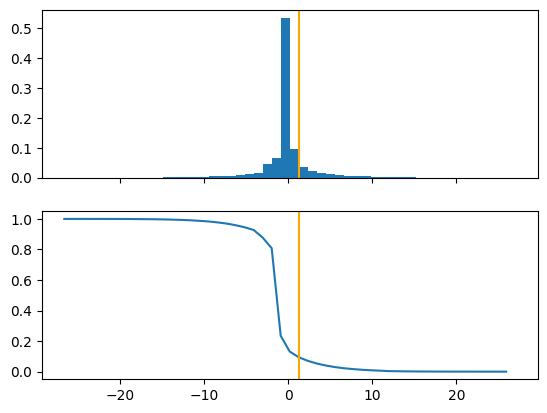

In [12]:
fig, axs = plt.subplots(nrows=2, sharex=True)
# TODO: how many bins????
count, bins, _ = axs[0].hist(shuffle_error, bins=50, density=True)
axs[0].axvline(mean_error, c="orange")
cdf = np.cumsum(count) / count.sum()
axs[1].plot(bins[:-1], 1 - cdf)
axs[1].axvline(mean_error, c="orange")

# calculate significance level
index = np.argmax((bins - mean_error) > 0)
print("mean error of shuffled data: ", shuffle_error.mean())
# TODO: left or right bucket for p-value -> or linear interpolation
print(f"Significance level of mean error= {mean_error} = {(1 - cdf)[index + 1]}") 


What is the general trend of the error in  model 1

coef:  [1.26162509 0.00376114]
(36, 72)


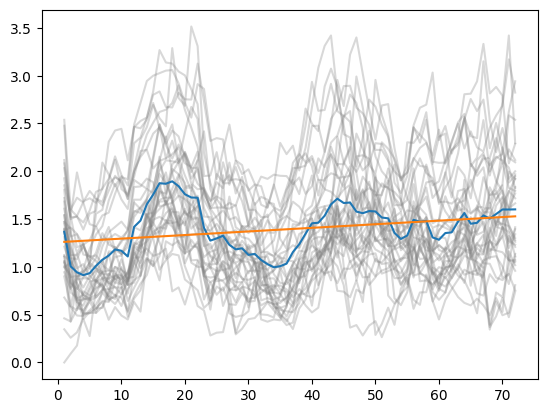

In [24]:
# transform list of errors into a 3d matrix
error_matrix = dataset.get_matrix("precipitation_error")

fig, ax = plt.subplots()

#error per station per day into the future 
station_errors = error_matrix.mean(axis=0)

x_axis = np.arange(1, 73)

ax.plot(x_axis, station_errors.T, label="station mean error", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax.plot(x_axis, forecast_error)

# extract trend
x = np.arange(72)[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax.plot(x_axis, regression)
print("coef: ", regression_coef)

# TODO: ask if we would use bar plots -> h
print(station_errors.shape)

In [14]:
N_BOOT = 1000000
x = np.arange(72)[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
X = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T

coefs = np.empty((N_BOOT, x_aug.shape[1]))
for i in tqdm(range(N_BOOT)):
    # shape: (num_pred_steps, num_stations)
    temp = forecast_error.copy()
    np.random.shuffle(temp)
    regression_coef = X @ temp
    coefs[i] = regression_coef

100%|██████████| 1000000/1000000 [00:06<00:00, 155371.85it/s]


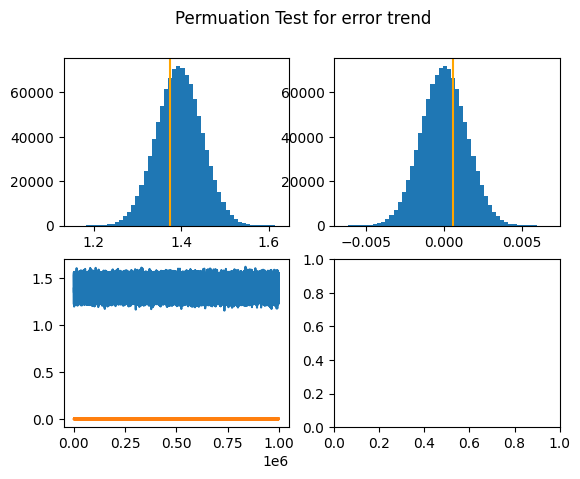

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2)

fig.suptitle("Permuation Test for error trend")
axs[0, 0].hist(coefs[:, 0], bins=50)
axs[0, 0].axvline(regression_coef[0], c="orange")
axs[0, 1].hist(coefs[:, 1], bins=50)
axs[0, 1].axvline(regression_coef[1], c="orange")

axs[1, 0].plot(coefs)

get confidence intervalls of the mean curve (blue) with bootstrap

In [16]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 100000

error_matrix = dataset.get_matrix("precipitation_error")

flatten_errors = np.concatenate(error_matrix, axis=0)
N = len(flatten_errors)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = []
for time_step_error in tqdm(flatten_errors.T):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


 92%|█████████▏| 66/72 [02:34<00:14,  2.34s/it]


KeyboardInterrupt: 

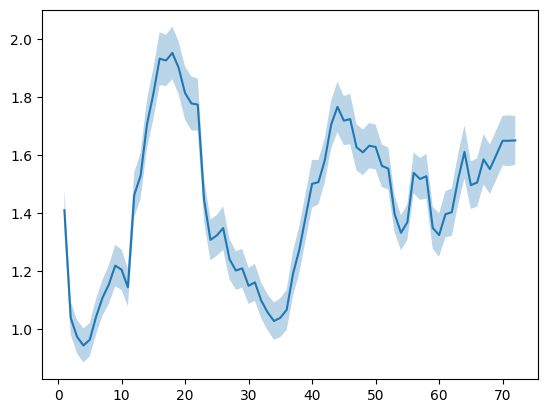

In [ ]:
fig, ax = plt.subplots()
x_axis = np.arange(1, 73)
mean = boot_strap_means.mean(axis=1)
std = boot_strap_means.std(axis=1)

ax.plot(x_axis, mean)
ax.fill_between(x_axis, mean - std, mean + std, alpha=0.3)

# TODO: ellipse plots???? 


look at the covariance between the estimated mean and the estimated standard variance. 

array([[153.2898243 ,   8.01715619],
       [  8.01715619,   0.42268864]])

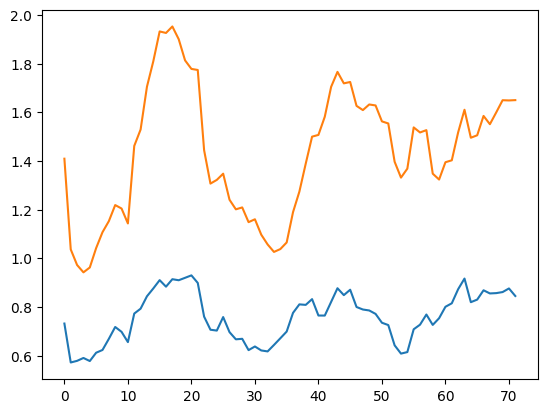

In [ ]:
fig, ax = plt.subplots()

ax.plot(std * 10)
ax.plot(mean)

estimator_properties = np.stack([mean, std]).T
estimator_properties.T @ estimator_properties

In [ ]:
hourly = df[df["provider"] == "DWD_1"]
q811 = hourly[hourly["station_id"] == "Q811"]



fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

NameError: name 'df' is not defined

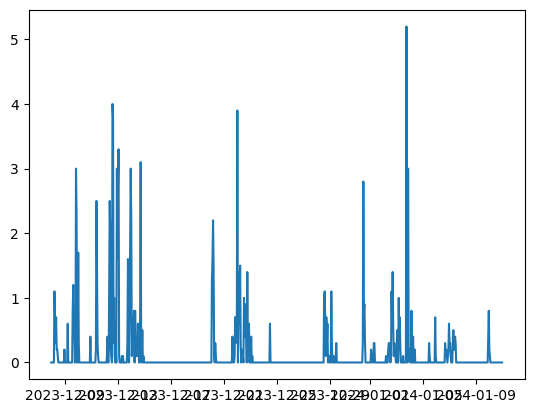

In [ ]:
# find station id to Stationskennung Q811
import pandas as pd

from studies.utils.recent import get_recent
from project.process.utils.download_dwd_data import FEATURE_STATION_PROPERTY_MAP
import glob

stations_df = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

station_id = stations_df[stations_df["Stations-kennung"] == "Q811"]["Stations_ID"].unique()[0]


# load real data for station_id
property = "precipitation"
recent_df = get_recent(feature=property)
recent_df = recent_df.rename(columns={"MESS_DATUM": "time"})
recent_df = recent_df[recent_df["STATIONS_ID"] == station_id]
recent_df = recent_df[["STATIONS_ID", "time", "  R1"]]
recent_df = recent_df[recent_df["time"] >= min_time]
recent_df = recent_df[recent_df["time"] <= max_time]

# plot recent precipitation
fig, ax = plt.subplots()
ax.plot(recent_df["time"], recent_df["  R1"])

Here I want ot calculate the errors of a prediction

In [ ]:
# load prediction
provider = "DWD_1"
station_id = "Q811"
feature = "precipitationTotal"

In [ ]:
forecasts = get_dwd_forecast(feature)
forecasts = forecasts[forecasts["provider"] == provider]
# forecasts = forecasts[forecasts["station_id"] == station_id]
recent = get_recent("precipitation")
stations = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

def get_station_id(stations_kennung: str):
    station_id = list(stations[stations["Stations-kennung"] == stations_kennung]["Stations_ID"].unique())[0]
    return station_id

forecasts["station_id"] = forecasts["station_id"].apply(get_station_id)

In [ ]:
from studies.utils.forecast import set_errors_to_zeros


recent = recent.rename(columns={"MESS_DATUM": "time", "STATIONS_ID": "station_id"})
recent["  R1"] = recent["  R1"].apply(set_errors_to_zeros)
merge = pd.merge(forecasts, recent, on=["time", "station_id"], how="left")
merge = merge.assign(error=lambda x: x['precipitationTotal'] - x['  R1'])
# exclude station_id=1239
merge = merge[merge["station_id"] != 1239]

Text(0.5, 0, 'Datetime of comparison')

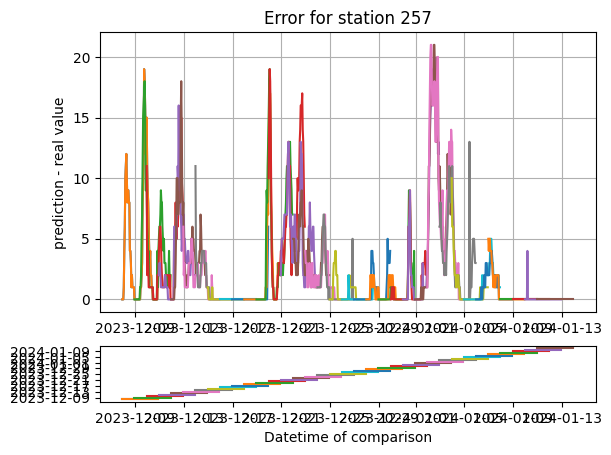

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

station_id = 257
axs[0].set_title(f"Error for station {station_id}")
for call_time in sorted(forecasts["call_time"].unique()):
    call_time_forecast = merge[(merge["call_time"] == call_time) & (merge["station_id"] == station_id)]
    forecast_time = call_time_forecast["time"]
    axs[0].plot(forecast_time, call_time_forecast["precipitationTotal"])
    axs[1].plot((min(forecast_time), max(forecast_time)), (call_time, call_time))

axs[0].grid()
axs[0].set_ylabel("prediction - real value")
axs[1].set_xlabel("Datetime of comparison")

We can obsever in this plot that the error is basically greater than zero. This means the forecast is more prone to predict more rain than in real life

In [ ]:
errors = []
station_ids = merge["station_id"].unique()

for call_time in sorted(merge["call_time"].unique()):
    same_call_time = merge[merge["call_time"] == call_time]
    call_time_errors = []
    for station_id in station_ids:
        call_time_error = same_call_time[same_call_time["station_id"] == station_id]["error"].values
        call_time_error = call_time_error[:72]  # This is a HACK and needs to be resolved
        call_time_errors.append(call_time_error)
    errors.append(np.stack(call_time_errors))
    time = same_call_time["time"].values 

# shape: (num_api_calls, num_stations, num_predictions_into_future)
errors = np.stack(errors)
num_errors_per_call_time = np.isnan(errors).sum(axis=2).sum(1)
print(num_errors_per_call_time)
# print(list(zip(merge["call_time"].unique(), num_errors_per_call_time)))
# errors = np.abs(errors)
# ax.plot(x, np.stack(errors).mean(axis=0))
"""fig, ax = plt.subplots()
for call_time_error in errors:
    for station_error in call_time_error:
        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")
mean_error = np.concatenate(errors, axis=0).mean(axis=0) 
ax.plot(mean_error, label="mean")
ax.set_ylabel("predicted precipitation - real precipitation")
ax.set_xlabel("time steps into the future")"""

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  805 1645 2485]


'fig, ax = plt.subplots()\nfor call_time_error in errors:\n    for station_error in call_time_error:\n        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")\nmean_error = np.concatenate(errors, axis=0).mean(axis=0) \nax.plot(mean_error, label="mean")\nax.set_ylabel("predicted precipitation - real precipitation")\nax.set_xlabel("time steps into the future")'

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

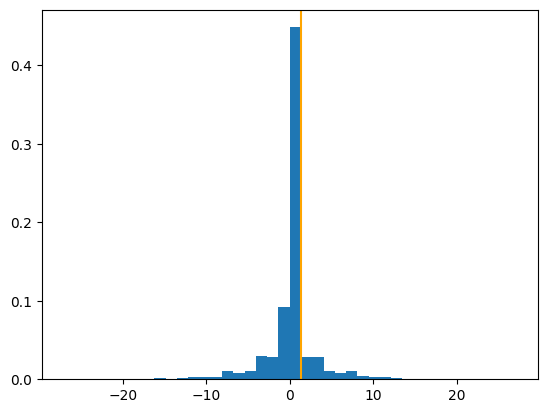

In [ ]:
from sklearn.utils import shuffle

prediction = merge["precipitationTotal"].values
real = merge["  R1"].values

# exclude nan values
mask = np.isnan(prediction) + np.isnan(real)
prediction = prediction[~mask]
real = real[~mask]
mean_error = (prediction - real).mean()

data = np.concatenate([prediction, real])
scrambled = shuffle(data)
scrambled = np.stack([scrambled[:len(prediction)], scrambled[len(prediction):]])
error = scrambled[0] - scrambled[1]

fig, ax = plt.subplots()
hist, bins = np.histogram(error, bins=40, density=True)
ax.hist(error, bins=40, density=True)
ax.axvline(mean_error, color="orange")


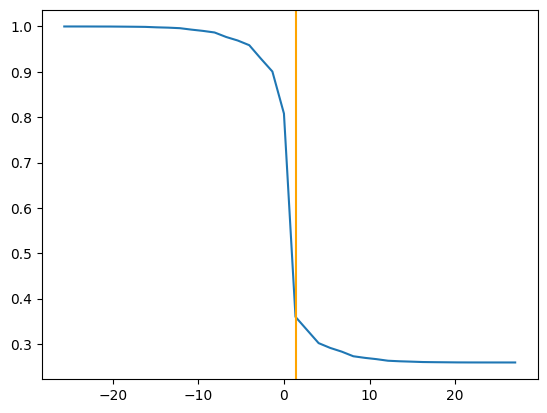

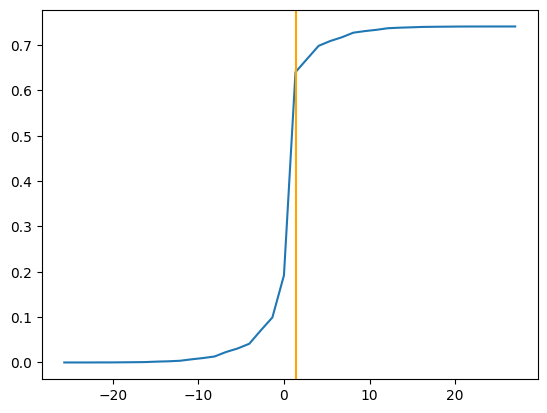

In [ ]:
fig, ax = plt.subplots()
ax.plot(bins[1:], 1- hist.cumsum())
ax.axvline(mean_error, color="orange")

fig, ax = plt.subplots()
ax.plot(bins[1:], hist.cumsum())
ax.axvline(mean_error, color="orange")


IS one location espacially prone for errors?


In [ ]:
errors = np.stack(errors)
fig, ax = plt.subplots()
for station_id, station_error in zip(station_ids, errors.swapaxes(0, 1)):
    ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3)

ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3, label="station mean error")

mean_error = errors.mean(axis=0)
mean_error = mean_error.mean(axis=0)
ax.plot(mean_error, label="meanerror")

# line fitting
mask = np.isnan(mean_error)
x = np.arange(72)[:, None][~mask]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
covariance = x_aug.T @ x_aug
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @x_aug.T @ mean_error[~mask]

fit = x_aug @ regression_coef
ax.plot(x, fit, label="linear regression")
ax.legend()
ax.set_xlabel("prediction step into the future")
ax.set_ylabel("prediction - real")

NameError: name 'errors' is not defined

In [ ]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000
N = len(flatten_errors)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = []
for time_step_error in tqdm(errors.swapaxes(0, 2)):
    flatten_errors = time_step_error.flatten()
    simulated_errors = np.random.choice(flatten_errors, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


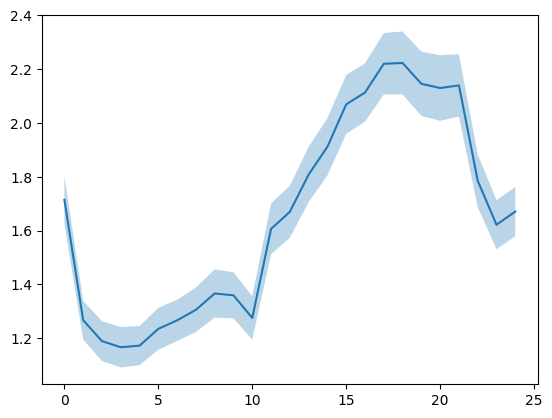

In [ ]:
fig, ax = plt.subplots()
stds = np.std(boot_strap_means, axis=1)

ax.plot(mean_error)
ax.fill_between(np.arange(72), mean_error - stds, mean_error + stds, alpha=0.3)

IS one location espacially prone for errors?

Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error 

Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

